In [1]:
import pandas as pd
from allocations import Allocations
import matplotlib.pyplot as plt
import numpy as np

In [52]:
methods = [
    "fasterrisk",
    "bootstrap_nn",
    "nn_variance",
    "awp"]

labels = [
    "Feature Selection",
    "Training Data",
    "Training Initialization",
    "Weight Perturbation"
]

SELECTION_RATE = 0.25
QUALIFICATION_COLUMN = "qualified_gagne_2"
ITERATIONS_PER_SPLIT = 25
TEST_SIZE = 1000
RASHOMON_EPSILON = 0.01
USE_BEST = True

output_file = "viz/sickness_ratio.jpg"
if USE_BEST:
    output_file = "viz/sickness_ratio_best.jpg"
data = pd.read_csv("data/obermeyer/obermeyer_data_cleaned.csv")

In [41]:
all_results = []
baseline = []

for m in methods:
    print(m)
    #df = pd.read_csv("results/"+m+"_"+QUALIFICATION_COLUMN+".csv")
    df = pd.read_csv("test_bootstrap_lr_qualified_gagne_2.csv")
    a = Allocations(df, TEST_SIZE, SELECTION_RATE, "y", RASHOMON_EPSILON, ITERATIONS_PER_SPLIT)
    allocations, people = a.get_allocations()

    results = []
    for seed in allocations["seed"].unique():
        for iteration in allocations["iteration"].unique():
            curr_people = list(people.loc[((people["seed"]==seed)&(people["iteration"]==iteration)), "people"])[0]
            test_data = data.loc[data["person_id"].isin(curr_people), ["person_id", QUALIFICATION_COLUMN, "race"]]
    
            curr_allocations = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "selected"].to_list()
            results_inner = []
            for a in curr_allocations:
                results_inner.append(test_data.loc[test_data["person_id"].isin(a), "race"].sum() / len(a))

            if USE_BEST:
                results.append(max(results_inner))
            else:
                results += results_inner
                            
            # Baseline Simulations
            qualified = test_data[test_data[QUALIFICATION_COLUMN]==1]
            unqualified = test_data[test_data[QUALIFICATION_COLUMN]==0]
            k = int(TEST_SIZE*SELECTION_RATE)
            k_prime = int(np.round(allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "k'"].mean()))
            k_minus_k_prime = k - k_prime

            if USE_BEST:
                group_qualified = len(qualified[qualified["race"]==1])
                group_unqualified = len(unqualified[unqualified["race"]==0])
                baseline.append((min(k_prime, group_qualified) + min(k_minus_k_prime, group_unqualified))/k)
            else:
                for i in range(100):
                    selected = pd.concat([qualified.sample(n=k_prime), unqualified.sample(n=k_minus_k_prime)])                
                    baseline.append(selected["race"].sum()/len(selected))
    all_results.append(results)

fasterrisk
bootstrap_nn
nn_variance
awp


In [42]:
all_results.append(baseline)
all_results.reverse()
labels.reverse()

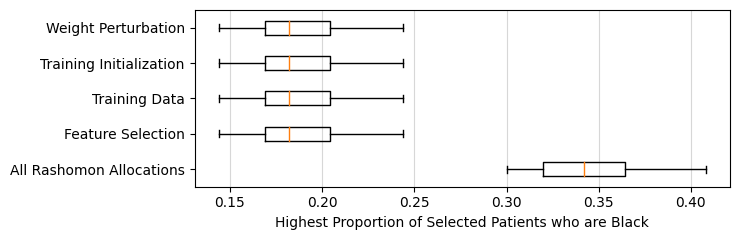

In [57]:
fig, ax = plt.subplots(figsize=(7.5,2.5))
bp_dict = ax.boxplot(all_results, showfliers=False, vert=False, notch=False, widths=0.4)

ax.set_yticklabels(["All Rashomon Allocations"]+labels)

if USE_BEST:
    ax.set_xlabel("Highest Proportion of Selected Patients who are Black")
else:
    ax.set_xlabel("Proportion of Selected Patients who are Black")

plt.grid(True, axis='x', alpha=0.5)
fig.tight_layout()
fig.savefig(output_file, dpi=500)